*Script criado por Natália Machado Crespo em Jan/2022 para o curso Aplicações em meteorologia usando Python*

*Revisado por Rafael Cesario de Abreu*

# Aula 3 - Dados multivariados 
Dados que variam no tempo e no espaço (netCDF; dados de reanálise, modelos etc.). Nesta aula aprenderemos a fazer:

*   Climatologias espaciais
*   Cálculo de anomalias
*   Remoção de tendência
*   Visualização de perfis verticais em um ponto arbitrário do mapa
*   Selecionando dados de uma região específica através do uso de máscaras

**O que é NetCDF?**

**Network Common Data Form** é um conjunto de interfaces e bibliotecas de softwares para acesso de dados orientados, distribuído gratuitamente para diversos tipos de linguagens. 

As bibliotecas netCDF consistem em um formato independente que representam dados científicos. As **interfaces + bibliotecas + formatos** permitem a criação, acesso e compartilhamento de dados científicos.

**Pacotes**

* **XARRAY:** é um projeto aberto e pacote do Python que facilita o trabalho com dados multidimensionais. O Xarray utiliza *labels* na forma de dimensões, coordenadas e atributos em cima de *arrays* do tipo NumPy, por exemplo, possibilitando uma experiência mais intuitiva e concisa. É inspirado no pacote *pandas* e é particularmente utilizado para trabalhar com dados netCDF.


* **CARTOPY:** é um pacote do Python desenhado para o processamento de dados geoespaciais, a fim de confeccionar mapas e fazer outras análises espaciais. O Cartopy utiliza as bibliotecas PROJ, NumPy e Shapely além da biblioteca Matplotlib, para gerar mapas de alta qualidade.

* **SCIPY:** é uma coleção de algoritmos matemáticos e funções criada na extensão do NumPy do Python. Proporciona ao usuário comandos para manipular e visualizar dados.

Geralmente alguns pacotes básicos já vêm instalados no Colab e Anaconda. Podemos usar o comando `!pip freeze` aqui no Colab para vermos quais pacotes estão instalados. 
Esse comando também serve para o python no terminal do Linux. Já para o Anaconda, seria o `conda list`.

In [ ]:
!pip freeze

In [ ]:
#Instalando o Cartopy, juntamente com pacotes e versões necessárias para o seu bom funcionamento no Colab.
!pip uninstall -y shapely
!pip install -q netcdf4
!pip install shapely cartopy --no-binary shapely --no-binary cartopy

Found existing installation: Shapely 1.8.0
Uninstalling Shapely-1.8.0:
  Successfully uninstalled Shapely-1.8.0
  Using cached Shapely-1.8.0.tar.gz (278 kB)
Skipping wheel build for shapely, due to binaries being disabled for it.
    Running setup.py install for shapely ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
#Importando bibliotecas que iremos utilizar ao longo do código
import matplotlib.pyplot as plt #pacote para plot
import numpy as np #pacote para comandos gerais com os dados

import xarray as xr #pacote para abrir e trabalhar com o netcdf

from scipy.signal import detrend #pacote estatístico para remover tendência

import cartopy.crs as ccrs #pacote para mapas (coordinate reference systems)
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

Vamos primeiro dar uma olhada na cara dos arquivos utilizando o `xarray`

In [ ]:
#Montando o drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Abrindo o arquivo netcdf que está no drive
ds = xr.open_dataset('/content/drive/Shareddrives/Curso_Python2022/dados_NCEP_NOAA/air.mon.mean.nc')
ds

<xarray.Dataset>
Dimensions:    (lat: 73, level: 17, lon: 144, nbnds: 2, time: 507)
Coordinates:
  * level      (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-03-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    air        (time, level, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by Hoop (netCDF2.3)\nConverted to chunked...

Vamos selecionar o ponto mais próximo ao IAG `(method = 'nearest')` no conjunto de dados e plotar a temperatura em 1000 hPa (`level = 1000`) para todo o período de tempo disponível (`iag[:]`). Lembrando que Lat e Lon da estação do IAG são -23.60, -46.67; e que a longitude deve ser considerada entre 0 e 360° (veja o output acima da coordenada `lon`).

In [ ]:
iag = ds['air'].sel(lat = -23.60, lon = 313.33, level= 1000, method = 'nearest')

Fazendo o plot da mesma forma como utilizando o pacote `pandas`. Aqui vemos as semelhanças entre os pacotes.

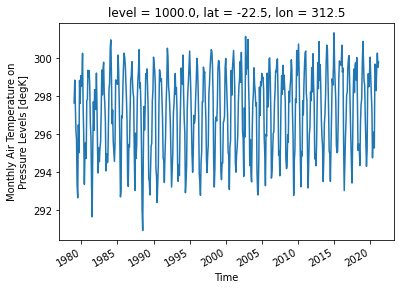

In [ ]:
iag[:].plot()


Outra forma de fazermos o *plot*: utilizando o `plt.plot()`. 
Vejam que aqui teríamos que configurar os eixos x e y e labels para sabermos o que cada um significa, enquanto que no outro comando isto é feito automaticamente. Dessa forma, o *plot* com o `xarray` acaba sendo útil para vizualizações rápidas, já que exige menos configurações.


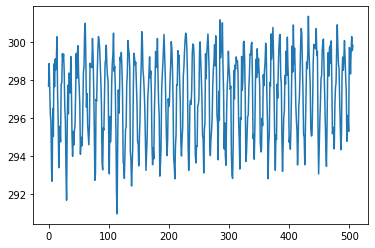

In [ ]:
plt.plot(iag[:])

#Climatologias espaciais sazonais

Utilizamos o comando `resample`, que faz uma "reamostragem" do nosso conjunto de dados. Importante: para o `resample` funcionar, ele deve ser aplicado no eixo do tempo, onde esta dimensão deve ser do tipo `datetime`.

In [ ]:
seas = ds['air'].resample(time='Q-NOV').mean(dim=['time'])

Visualizando como ficaram os dados:

In [ ]:
 seas # Vejam que o número de tempos diminuiu.

<xarray.DataArray 'air' (time: 170, level: 17, lat: 73, lon: 144)>
array([[[[242.33   , 242.33   , 242.33   , ..., 242.33   , 242.33   ,
          242.33   ],
         [241.95999, 241.98   , 242.005  , ..., 241.9    , 241.92   ,
          241.935  ],
         [241.76   , 241.73999, 241.725  , ..., 241.83499, 241.81   ,
          241.785  ],
         ...,
         [264.81   , 264.7    , 264.58502, ..., 265.12   , 265.02502,
          264.91998],
         [262.66998, 262.605  , 262.53497, ..., 262.86   , 262.8    ,
          262.73502],
         [261.69998, 261.69998, 261.69998, ..., 261.69998, 261.69998,
          261.69998]],

        [[245.66   , 245.66   , 245.66   , ..., 245.66   , 245.66   ,
          245.66   ],
         [245.51001, 245.56   , 245.605  , ..., 245.37   , 245.42   ,
          245.465  ],
         [245.22   , 245.325  , 245.425  , ..., 244.875  , 244.995  ,
          245.105  ],
...
         [221.49355, 221.4919 , 221.48628, ..., 221.52095, 221.51048,
          221.50485],
         [221.62744, 221.62502, 221.62503, ..., 221.63066, 221.63145,
          221.62581],
         [221.82982, 221.82982, 221.82982, ..., 221.82982, 221.82982,
          221.82982]],

        [[212.2734 , 212.2734 , 212.2734 , ..., 212.2734 , 212.2734 ,
          212.2734 ],
         [211.70485, 211.69354, 211.68387, ..., 211.7419 , 211.7274 ,
          211.71451],
         [211.09032, 211.075  , 211.04759, ..., 211.171  , 211.14352,
          211.11932],
         ...,
         [223.35968, 223.36047, 223.36691, ..., 223.35078, 223.35078,
          223.35161],
         [223.49272, 223.49597, 223.50885, ..., 223.4847 , 223.4871 ,
          223.49356],
         [223.61208, 223.61208, 223.61208, ..., 223.61208, 223.61208,
          223.61208]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-02-28 1979-05-31 ... 2021-05-31
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

A série temporal para a estação do IAG:

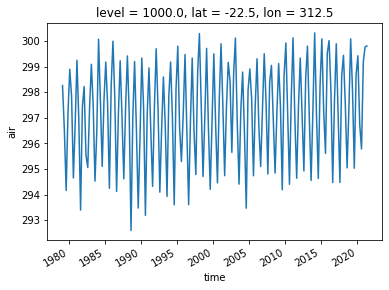

In [ ]:
seas.sel(lat = -23.60, lon = 313.33, level= 1000, method = 'nearest').plot()

Obtemos a climatologia de todo período utilizando o `groupby` de forma similar ao `pandas`. Uma facilidade é que podemos adicionar a *string* `'time.season'` para referenciar as estações DJF, MAM, JJA e SON.

In [ ]:
seas_all = seas.groupby('time.season').mean(dim=['time']) # aplicando o comando "mean" temos a média de todos os anos, por estação

In [ ]:
seas_all # Vejam como ficou o eixo do tempo: agora é chamado de "season" por conta do agrupamento aplicado.

<xarray.DataArray 'air' (season: 4, level: 17, lat: 73, lon: 144)>
array([[[[248.02696, 248.02696, 248.02696, ..., 248.02696, 248.02696,
          248.02696],
         [248.53372, 248.59184, 248.64848, ..., 248.3571 , 248.41667,
          248.4755 ],
         [249.25075, 249.34572, 249.43945, ..., 248.95844, 249.056  ,
          249.15373],
         ...,
         [264.28427, 264.175  , 264.06662, ..., 264.60767, 264.50162,
          264.39334],
         [262.98328, 262.92154, 262.86026, ..., 263.1705 , 263.10767,
          263.04565],
         [263.24738, 263.24738, 263.24738, ..., 263.24738, 263.24738,
          263.24738]],

        [[249.60207, 249.60207, 249.60207, ..., 249.60207, 249.60207,
          249.60207],
         [250.35371, 250.40979, 250.4628 , ..., 250.17271, 250.23605,
          250.29619],
         [251.02637, 251.16684, 251.29744, ..., 250.56468, 250.72516,
          250.87936],
...
         [218.89743, 218.94745, 219.00137, ..., 218.76674, 218.80676,
          218.85062],
         [219.36647, 219.38951, 219.41553, ..., 219.30301, 219.32262,
          219.34392],
         [220.12375, 220.12375, 220.12375, ..., 220.12375, 220.12375,
          220.12375]],

        [[211.87149, 211.87149, 211.87149, ..., 211.87149, 211.87149,
          211.87149],
         [211.24915, 211.25049, 211.2531 , ..., 211.25414, 211.25125,
          211.24988],
         [210.79909, 210.79936, 210.80281, ..., 210.81584, 210.80655,
          210.8007 ],
         ...,
         [234.5595 , 234.62212, 234.68523, ..., 234.38446, 234.44106,
          234.49916],
         [234.6939 , 234.72586, 234.75871, ..., 234.60133, 234.6309 ,
          234.66135],
         [235.05222, 235.05222, 235.05222, ..., 235.05222, 235.05222,
          235.05222]]]], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

Para plotar o mapa, vamos reparar que o objeto DataArray `seas_all` tem as dimensões: `season: 4, level: 17, lat: 73, lon: 144`. Logo, para visualizarmos apenas a primeira estação (season = 0 = DJF), o primeiro nível (level = 0 = 1000 hPa), para todas as 73 latitudes e para todas as 144 longitudes, usamos: `seas_all[0,0,:,:]`

De forma análoga, poderíamos utilizar os comandos `sel` que funciona utilizando os `labels` das coordenadas, ou `isel` que utiliza o índice. Utilizando o `sel` teríamos o seguinte comando: `seas_all.sel(season='DJF', level=1000)` e usando o comando `isel` teríamos `seas_all.isel(season=0, level=0)`

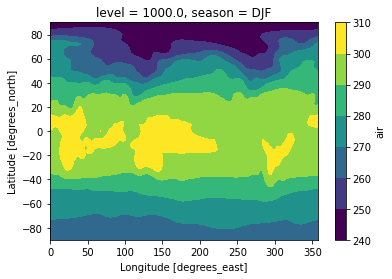

In [ ]:
# O comando "robust" configura os valores entre percentis 10% e 90%
seas_all[0,0,:,:].plot.contourf(robust=True)

Aqui utilizo o `matplotlib`. Outra forma de plotarmos. Vejam que precisaria configurar os eixos também.

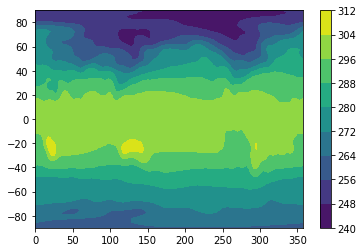

In [ ]:
plt.contourf(seas_all.lon,seas_all.lat, seas_all[0,0,:,:])
plt.colorbar()

Para fazer um mapa mais sofisticado com os continentes utilizamos o `cartopy`.

**Importante!** A longitude dos dados do NCEP estão de 0 a 360°. 
Iremos transformá-los para -180° a +180° por questões práticas no `cartopy`. Para isso, editamos a coordenada `'lon'` do objeto.

Passo a passo:


*   `seas_all.coords['lon'] + 180`: 0 a 360 se torna 180 a 540
*   `(seas_all.coords['lon'] + 180) % 360`: calcula o resto da divisão por 360, ou seja, 180, ..., 357.5, 0, 2.5, ..., 177.5 (se for uma resolução de 2.5°)
* `(seas_all.coords['lon'] + 180) % 360 - 180`: subtrai 180 tornando 0, 2.5, ..., 177.5, -180, -177.5, ..., -2.5
* `seas_all.sortby(seas_all.lon)`: mudamos as coordenadas mas o mapa continua igual, dessa forma ordenando pela longitude temos: -180, -177.5, ..., 0, 2.5, ..., 177.5. O `sortby` garante que não apenas as coordenadas serão ordenadas mas todos os dados do objeto.  

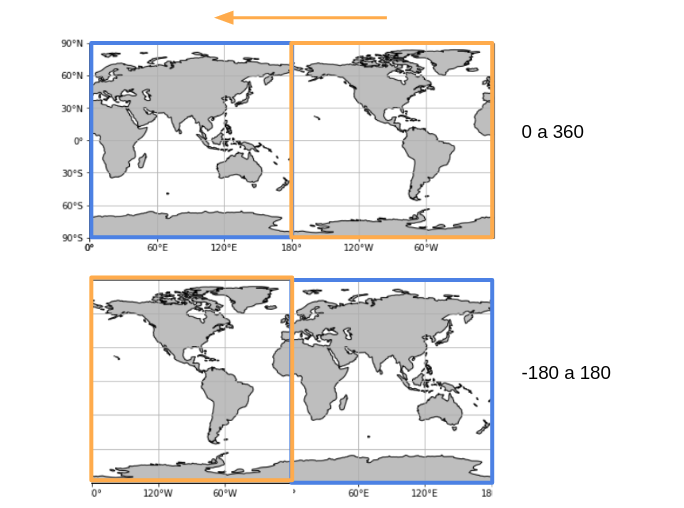


In [ ]:
seas_all.coords['lon'] = (seas_all.coords['lon'] + 180) % 360 - 180
seas_all = seas_all.sortby(seas_all.lon)

In [ ]:
seas_all  # repare nas longitudes

<xarray.DataArray 'air' (season: 4, level: 17, lat: 73, lon: 144)>
array([[[[248.02696, 248.02696, 248.02696, ..., 248.02696, 248.02696,
          248.02696],
         [247.4901 , 247.46355, 247.438  , ..., 247.56477, 247.5398 ,
          247.51538],
         [247.45285, 247.42885, 247.39873, ..., 247.49425, 247.48515,
          247.47188],
         ...,
         [266.60846, 266.64227, 266.67233, ..., 266.46854, 266.5229 ,
          266.56787],
         [265.01624, 265.0575 , 265.09528, ..., 264.86893, 264.92184,
          264.97165],
         [263.24738, 263.24738, 263.24738, ..., 263.24738, 263.24738,
          263.24738]],

        [[249.60207, 249.60207, 249.60207, ..., 249.60207, 249.60207,
          249.60207],
         [248.99785, 248.98592, 248.97336, ..., 249.03473, 249.02252,
          249.0101 ],
         [248.96997, 248.9417 , 248.91182, ..., 249.03589, 249.01666,
          248.99399],
...
         [222.19238, 222.14493, 222.0945 , ..., 222.3149 , 222.278  ,
          222.23714],
         [221.09987, 221.07663, 221.0509 , ..., 221.1605 , 221.14183,
          221.12096],
         [220.12375, 220.12375, 220.12375, ..., 220.12375, 220.12375,
          220.12375]],

        [[211.87149, 211.87149, 211.87149, ..., 211.87149, 211.87149,
          211.87149],
         [212.66122, 212.65993, 212.65746, ..., 212.65813, 212.6609 ,
          212.66219],
         [213.62456, 213.61858, 213.60963, ..., 213.62283, 213.62619,
          213.62654],
         ...,
         [236.29625, 236.2307 , 236.16322, ..., 236.481  , 236.42195,
          236.3603 ],
         [235.61922, 235.58504, 235.55124, ..., 235.71457, 235.6839 ,
          235.65248],
         [235.05222, 235.05222, 235.05222, ..., 235.05222, 235.05222,
          235.05222]]]], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

Voltando ao mapa:

**Dica**: Verifique os valores mínimos e máximos de temperatura em 1000 hPa (level = 0) antes de criar o *plot*. Assim você saberá como configurar a barra de cores.

In [ ]:
np.min(seas_all[:,0,:,:]) #240
np.max(seas_all[:,0,:,:]) #313

<xarray.DataArray 'air' ()>
array(313.34606934)
Coordinates:
    level    float32 1e+03

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


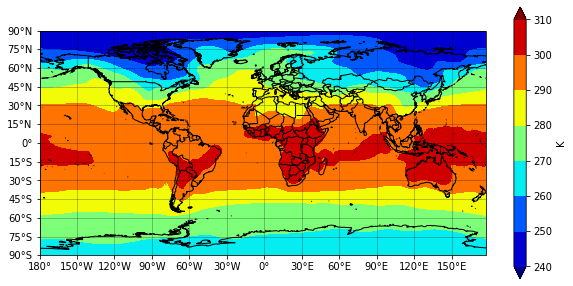

In [ ]:
#Ajustando o tamanho da figura; projeção cartográfica
fig, ax = plt.subplots(figsize=(10,5),subplot_kw={'projection': ccrs.PlateCarree()})

#Criando um array de valores que serão utilizados para os eixos de latitude e longitude do mapa
xticks = np.arange(-180,240,30)
yticks = np.arange(-90,105,15)

#Funções do cartopy
ax.coastlines('50m')
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

#Países
ax.add_feature(cfeat.BORDERS)

#Estados
states_provinces = cfeat.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='0.25')

#Linhas de grade
ax.grid(c='k', ls='-', alpha=0.3)

#Array de valores para a barra de cores
colorb=np.arange(240,320,10)

#Comando para fazer o plot da temperatura no mapa
cf = ax.contourf(seas_all.lon, seas_all.lat, seas_all[0,0,:,:], levels=colorb, extend='both', cmap='jet')

#Barra de cores
cbar=plt.colorbar(cf,ticks=colorb,label='K') 

# Calculando anomalias

Para calcular as anomalias vamos definir uma função que pega os dados de 1991 a 2020 e define uma climatologia, e, a partir dele, faz o cálculo da anomalia dos demais anos/meses

In [ ]:
#Função que calcula anomalia com base no período 1991-2020
def calc_anom(arq):
    arq_clima = arq.sel(time=slice('1991-01-01', '2020-12-31')).groupby('time.month').mean(dim='time', skipna=False)
    anom = arq.groupby("time.month") - arq_clima  # calculando anomalia
    return anom

**Dica**: Funções são ótimas formas de deixar seu código mais compacto, fácil de entender e reutilizável. Não faça funções muito complexas, pois fica difícil de *debugar*. Faça funções simples, com poucas linhas, que se encarreguem de realizar apenas UMA tarefa.

In [ ]:
anom = calc_anom(ds)  # calculando anomalia

In [ ]:
anom

<xarray.Dataset>
Dimensions:  (lat: 73, level: 17, lon: 144, time: 507)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-03-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    air      (time, level, lat, lon) float32 -2.793 -2.793 ... -1.194 -1.194

Plotando rapidamente o mapa

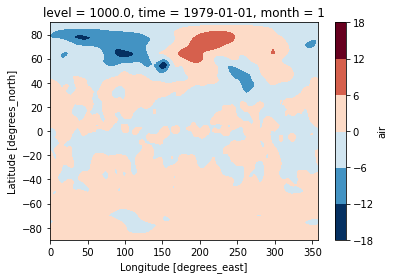

In [ ]:
anom.air[0,0,:,:].plot.contourf()

Agora fazendo o mapa com o `cartopy`:

In [ ]:
#Dica: verifique os valores mínimos e máximos de temperatura antes de criar o plot, assim você saberá como configurar a barra de cores
np.min(anom.air[:,0,:,:]) #-20
np.max(anom.air[:,0,:,:]) #13

<xarray.DataArray 'air' ()>
array(13.67097473)
Coordinates:
    level    float32 1e+03

In [ ]:
#Transformando as longitudes
anom.coords['lon'] = (anom.coords['lon'] + 180) % 360 - 180
anom = anom.sortby(anom.lon)

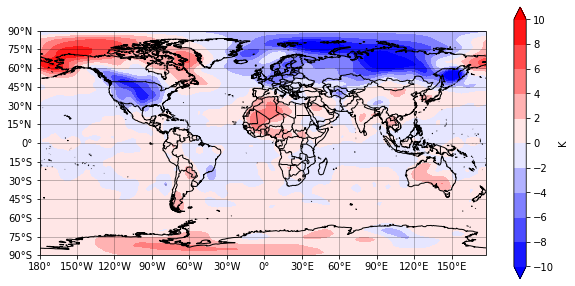

In [ ]:
#Ajustando o tamanho da figura; projeção cartográfica
fig, ax = plt.subplots(figsize=(10,5),subplot_kw={'projection': ccrs.PlateCarree()})

#Criando um array de valores que serão utilizados para os eixos de latitude e longitude do mapa
xticks = np.arange(-180,240,30)
yticks = np.arange(-90,105,15)

#Funções do cartopy
ax.coastlines('50m')
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

#Países
ax.add_feature(cfeat.BORDERS)

#Estados
states_provinces = cfeat.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='0.25')

#Linhas de grade
ax.grid(c='k', ls='-', alpha=0.3)

#Array de valores para a barra de cores
colorb=np.arange(-10,12,2)

#Comando para fazer o plot da temperatura no mapa
cf = ax.contourf(anom.lon,anom.lat, anom.air[0,0,:,:], levels=colorb, extend='both', cmap='bwr')

#Barra de cores
cbar=plt.colorbar(cf,ticks=colorb, label='K') 

#Removendo tendência dos dados

Um ponto importante muitas vezes é remover a tendência dos dados analisados, uma vez que muitos testes e métodos estatísticos necessitam de séries estacionárias para serem aplicados. A remoção da tendência pode ser feita de diversas formas: com regressão linear, polinômios de grau maior, *splines* etc. Nesse caso vamos usar uma regressão linear simples para isso.

Primeiramente vamos verificar as dimensões do dado que iremos remover a tendência.

In [ ]:
anom

<xarray.Dataset>
Dimensions:  (lat: 73, level: 17, lon: 144, time: 507)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-03-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    air      (time, level, lat, lon) float32 -2.793 -2.793 ... -1.194 -1.194

Ao usar o `detrend`, **tomar cuidado com o eixo onde será aplicado** (o padrão, ou seja, *default* é `axis=-1` que nesse caso seria a longitude)

In [ ]:
arq_det_anom = detrend(anom['air'], axis=0) #nesse caso, fazendo axis = 0 tenho a função aplicada no eixo do tempo, dimensão correta
#Uma alternativa ao comando acima seria: arq_det_anom = xr.apply_ufunc(detrend, anom[['air']], 0), que já retorna como um objeto do xarray.

In [ ]:
arq_det_anom

array([[[[ 3.24803591e-01,  3.24803591e-01,  3.24803591e-01, ...,
           3.24803591e-01,  3.24803591e-01,  3.24803591e-01],
         [ 1.83879471e+00,  1.93348622e+00,  2.03007150e+00, ...,
           1.53307009e+00,  1.62894201e+00,  1.73374271e+00],
         [ 3.68066120e+00,  3.89769340e+00,  4.11261272e+00, ...,
           3.00640202e+00,  3.23483753e+00,  3.45928931e+00],
         ...,
         [ 2.84201360e+00,  2.83572888e+00,  2.84244752e+00, ...,
           2.87233114e+00,  2.86008644e+00,  2.85808325e+00],
         [ 2.91353512e+00,  2.94505000e+00,  2.97735643e+00, ...,
           2.85862184e+00,  2.87656331e+00,  2.89807653e+00],
         [ 3.60277104e+00,  3.60277104e+00,  3.60277104e+00, ...,
           3.60277104e+00,  3.60277104e+00,  3.60277104e+00]],

        [[ 1.27370191e+00,  1.27370191e+00,  1.27370191e+00, ...,
           1.27370191e+00,  1.27370191e+00,  1.27370191e+00],
         [ 2.76935577e+00,  2.84722471e+00,  2.91418338e+00, ...,
           2.54004717e

In [ ]:
arq_det_anom.shape

(507, 17, 73, 144)

Quando aplicamos o comando `detrend` em um conjunto de dados o resultado será um ndarray (um objeto do `numpy` sem as camadas de metadados que o `xarray` possui). 

Então, precisamos voltar para o nosso DataArray utilizando comandos do `xarray`. Dessa forma, as coordenadas serão reconhecidas.


In [ ]:
arq_det_anom = xr.DataArray(arq_det_anom, dims=['time','level','lat','lon'],
                            coords={'time': anom.time,'level': anom.level,'lat': anom.lat,'lon': anom.lon})

Renomeamos a variável para sabermos que estamos de fato utilizando a temperatura do ar sem a tendência

In [ ]:
arq_det_anom.name = 'air_anom_detrended'

In [ ]:
arq_det_anom

<xarray.DataArray 'air_anom_detrended' (time: 507, level: 17, lat: 73, lon: 144)>
array([[[[ 3.24803591e-01,  3.24803591e-01,  3.24803591e-01, ...,
           3.24803591e-01,  3.24803591e-01,  3.24803591e-01],
         [ 1.83879471e+00,  1.93348622e+00,  2.03007150e+00, ...,
           1.53307009e+00,  1.62894201e+00,  1.73374271e+00],
         [ 3.68066120e+00,  3.89769340e+00,  4.11261272e+00, ...,
           3.00640202e+00,  3.23483753e+00,  3.45928931e+00],
         ...,
         [ 2.84201360e+00,  2.83572888e+00,  2.84244752e+00, ...,
           2.87233114e+00,  2.86008644e+00,  2.85808325e+00],
         [ 2.91353512e+00,  2.94505000e+00,  2.97735643e+00, ...,
           2.85862184e+00,  2.87656331e+00,  2.89807653e+00],
         [ 3.60277104e+00,  3.60277104e+00,  3.60277104e+00, ...,
           3.60277104e+00,  3.60277104e+00,  3.60277104e+00]],

        [[ 1.27370191e+00,  1.27370191e+00,  1.27370191e+00, ...,
           1.27370191e+00,  1.27370191e+00,  1.27370191e+00],
         [ 2.76935577e+00,  2.84722471e+00,  2.91418338e+00, ...,
           2.54004717e+00,  2.60597157e+00,  2.69207668e+00],
         [ 4.42215300e+00,  4.61762047e+00,  4.80593300e+00, ...,
           3.81154680e+00,  4.01777458e+00,  4.21816492e+00],
...
           2.94487894e-01,  3.12284410e-01,  3.26741219e-01],
         [ 3.86405766e-01,  3.99517119e-01,  4.06525373e-01, ...,
           3.75195980e-01,  3.82969677e-01,  3.86621475e-01],
         [ 3.81974161e-01,  3.81974161e-01,  3.81974161e-01, ...,
           3.81974161e-01,  3.81974161e-01,  3.81974161e-01]],

        [[-6.91360760e+00, -6.91360760e+00, -6.91360760e+00, ...,
          -6.91360760e+00, -6.91360760e+00, -6.91360760e+00],
         [-6.83750343e+00, -6.81650352e+00, -6.79262257e+00, ...,
          -6.90462780e+00, -6.88526630e+00, -6.85956192e+00],
         [-6.66922855e+00, -6.61476421e+00, -6.56817389e+00, ...,
          -6.83253574e+00, -6.77553654e+00, -6.71892929e+00],
         ...,
         [ 4.68740225e-01,  4.88182545e-01,  5.04747629e-01, ...,
           4.01268363e-01,  4.19360638e-01,  4.41994786e-01],
         [ 4.04981852e-01,  4.13288355e-01,  4.30493832e-01, ...,
           3.68497610e-01,  3.77776146e-01,  3.91307831e-01],
         [ 3.02732944e-01,  3.02732944e-01,  3.02732944e-01, ...,
           3.02732944e-01,  3.02732944e-01,  3.02732944e-01]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-03-01
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

Vamos comparar a série de anomalias com e sem tendência para o globo e para um ponto.

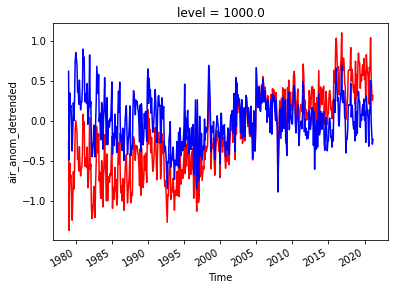

In [ ]:
#GLOBAL - nesse caso, fazemos a média nas dimensões lat e lon, obtendo a série temporal global
#Em vermelho a anomalia com tendência e em azul sem tendência
((anom.air.mean(dim=['lat', 'lon'])).sel(level= 1000)).plot(color='red')
((arq_det_anom.mean(dim=['lat', 'lon'])).sel(level= 1000)).plot(color='blue')

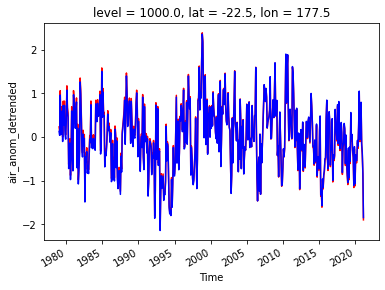

In [ ]:
#PARA UM PONTO - ponto próximo à estação do IAG
anom.air.sel(lat = -23.60, lon = 313.33, level= 1000, method = 'nearest').plot(color="red")
arq_det_anom.sel(lat = -23.60, lon = 313.33, level= 1000, method = 'nearest').plot(color="blue")

Agora vamos comparar os mapas espaciais com e sem tendência

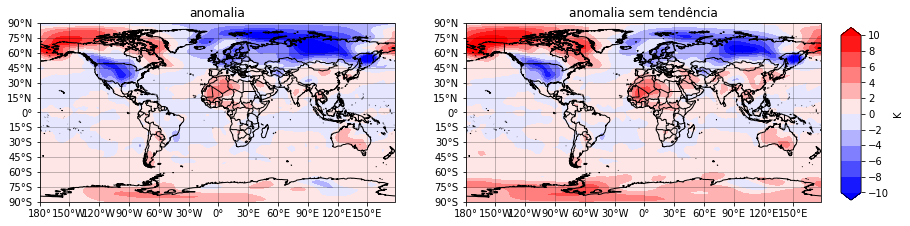

In [ ]:
#Ajustando o tamanho da figura; projeção cartográfica
fig, ax = plt.subplots(1, 2, figsize=(14,8),subplot_kw={'projection': ccrs.PlateCarree()})

#Criando um array de valores que serão utilizados para os eixos de latitude e longitude do mapa
xticks = np.arange(-180,240,30)
yticks = np.arange(-90,105,15)

#Array de valores para a barra de cores em ambos os plots
colorb=np.arange(-10,12,2)

#MAPA 1
#Funções do cartopy
ax[0].coastlines('50m')
ax[0].set_xticks(xticks, crs=ccrs.PlateCarree())
ax[0].set_yticks(yticks, crs=ccrs.PlateCarree())
ax[0].xaxis.set_major_formatter(LongitudeFormatter())
ax[0].yaxis.set_major_formatter(LatitudeFormatter())

#Países
ax[0].add_feature(cfeat.BORDERS)

#Estados
states_provinces = cfeat.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

#Linhas de grade
ax[0].grid(c='k', ls='-', alpha=0.3)

#Comando para fazer o plot da temperatura no mapa
cf = ax[0].contourf(anom.lon,anom.lat, anom.air[0,0,:,:], levels=colorb, extend='both', cmap='bwr')

#Título no mapa
ax[0].set_title('anomalia')

##################################################################################################
#MAPA 2
#Funções do cartopy
ax[1].coastlines('50m')
ax[1].set_xticks(xticks, crs=ccrs.PlateCarree())
ax[1].set_yticks(yticks, crs=ccrs.PlateCarree())
ax[1].xaxis.set_major_formatter(LongitudeFormatter())
ax[1].yaxis.set_major_formatter(LatitudeFormatter())

#Países
ax[1].add_feature(cfeat.BORDERS)

#Estados
states_provinces = cfeat.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='0.25')

#Linhas de grade
ax[1].grid(c='k', ls='-', alpha=0.3)

#Comando para fazer o plot da temperatura no mapa
cf = ax[1].contourf(arq_det_anom.lon,arq_det_anom.lat, arq_det_anom[0,0,:,:], levels=colorb, extend='both', cmap='bwr')

#Título no mapa
ax[1].set_title('anomalia sem tendência')

#Outra forma de adicionar a barra de cores (manualmente)
#Configuro o tamanho e posição da barra de cores (xmin, ymin, width, height)
cb_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3])
cbar = fig.colorbar(cf, cax=cb_ax, label='K')
cbar.set_ticks(colorb)

# Perfis verticais em um ponto arbitrário do mapa

Antes de entrarmos na parte das máscaras espaciais, vamos analisar o perfil vertical da temperatura: 

1) **para um ponto** (estação do IAG) 

2) **seção vertical** (nesse caso, para uma longitude específica, variando a latitude)

Text(0.5, 0, '°C')

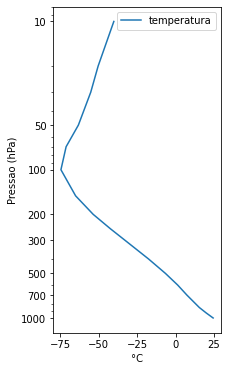

In [ ]:
#1) PARA UM PONTO
#Lat e lon da estação do IAG -23.60, -46.67
iag = (ds['air']-273.15).sel(lat = -23.60, lon = 313.33, method = 'nearest')

#Definindo a figura
fig,ax = plt.subplots(figsize=(3,6))

#Fazendo o plot utilizando o matplotlib
plt.plot(iag[0,:],iag.level,label='temperatura')

#Vejam que o gráfico está com o eixo y invertido e sem nenhuma informação nos eixos. Então vamos configurar.
#Comando para inverter o eixo
plt.gca().invert_yaxis()

#Podemos também utilizar a escala logaritmica, como comumente vemos nos mapas Skew-T
ax.set_yscale('log') #Vejam que os valores ficaram no formato exponencial. Vamos ajustá-los.

#Array com valores fixos para aparecerem no gráfico
yvalues = [10,50,100,200,300,500,700,1000]
ax.set_yticks(yvalues)
ax.set_yticklabels(yvalues, fontsize=10)

#Adicionando o label do plot
plt.legend(fontsize='medium', loc='best')

#Configurando o nome dos eixos
ax.set_ylabel('Pressao (hPa)')
ax.set_xlabel('°C')

Para a seção vertical com a mudança de latitude Vamos utilizar a longitude da estação do IAG

In [ ]:
iag_sec = (ds['air']-273.15).sel(lon = 312.5)

In [ ]:
iag_sec

<xarray.DataArray 'air' (time: 507, level: 17, lat: 73)>
array([[[-27.899994 , -27.519989 , -26.48999  , ...,  -1.0599976,
          -3.119995 ,  -5.480011 ],
        [-24.59999  , -24.830002 , -25.709991 , ...,  -5.139984 ,
          -7.3099976,  -9.589996 ],
        [-23.87999  , -23.519989 , -24.179993 , ...,  -9.110016 ,
         -11.949982 , -14.160004 ],
        ...,
        [-73.399994 , -74.04001  , -74.59     , ..., -36.97     ,
         -36.89     , -36.809998 ],
        [-71.92999  , -72.92999  , -73.66     , ..., -35.799988 ,
         -36.       , -35.929993 ],
        [-63.149994 , -64.54999  , -65.619995 , ..., -27.48999  ,
         -27.789993 , -28.       ]],

       [[-33.73999  , -35.20999  , -35.25     , ..., -13.73999  ,
         -16.049988 , -17.419998 ],
        [-30.37999  , -32.049988 , -34.179993 , ..., -17.690002 ,
         -20.169998 , -21.319992 ],
        [-28.89     , -29.709991 , -31.399994 , ..., -21.179993 ,
         -24.529999 , -25.709991 ],
...
        [-67.85625  , -69.3116   , -70.552704 , ..., -40.40712  ,
         -40.015198 , -39.780334 ],
        [-67.777695 , -68.86162  , -69.72856  , ..., -39.312485 ,
         -39.242813 , -39.13301  ],
        [-66.779434 , -67.32497  , -67.73393  , ..., -34.43747  ,
         -34.94371  , -35.149063 ]],

       [[-22.39354  , -22.355621 , -22.979004 , ..., -15.904022 ,
         -17.770966 , -19.410461 ],
        [-22.078232 , -22.107254 , -23.709671 , ..., -19.644318 ,
         -21.835464 , -23.431458 ],
        [-23.982254 , -23.454056 , -24.129837 , ..., -22.944351 ,
         -26.067749 , -27.824203 ],
        ...,
        [-68.04756  , -67.08147  , -65.894394 , ..., -51.349228 ,
         -51.456436 , -51.457245 ],
        [-66.61046  , -66.11694  , -65.4355   , ..., -51.366898 ,
         -51.42015  , -51.320175 ],
        [-60.876587 , -61.09517  , -61.288696 , ..., -49.67903  ,
         -49.657272 , -49.537918 ]]], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
    lon      float32 312.5
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-03-01

In [ ]:
np.min(iag_sec[0,:]) #-80
np.max(iag_sec[0,:]) #26

<xarray.DataArray 'air' ()>
array(26.93002319)
Coordinates:
    lon      float32 312.5
    time     datetime64[ns] 1979-01-01

Text(0.5, 1.0, 'Seção vertical')

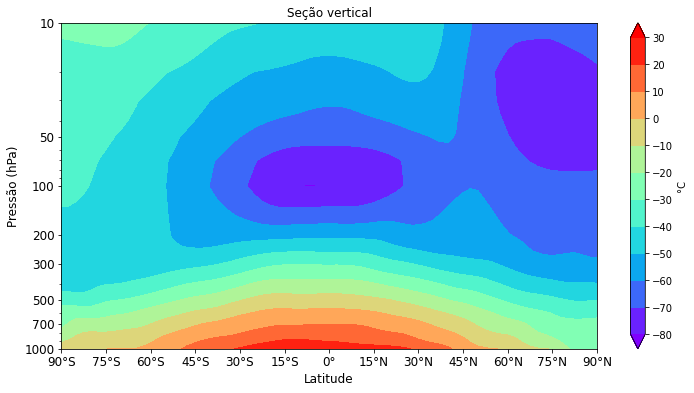

In [ ]:
#Definindo a figura
fig, ax = plt.subplots(figsize=(12,6))

#Array para escala de cores
colorb=np.arange(-80,40,10)

#Fazendo o plot de seção vertical
sv = ax.contourf(ds.lat, ds.level, iag_sec[0,:], levels=colorb, extend = 'both', cmap='rainbow')

#Vejam que precisamos configurar os eixos

#Invertemos
plt.gca().invert_yaxis()
#Aplicando escala log
ax.set_yscale('log')

#Array com valores fixos para aparecerem no gráfico
yvalues = [10,50,100,200,300,500,700,1000]
ax.set_yticks(yvalues)
ax.set_yticklabels(yvalues, fontsize=12)
xvalues = np.arange(-90,105,15)
ax.set_xticks(xvalues)
ax.set_xticklabels(xvalues, fontsize=12)
#Utilizando a formatação do cartopy para a latitude
ax.xaxis.set_major_formatter(LatitudeFormatter())

#Configurando o nome dos eixos
ax.set_ylabel('Pressão (hPa)',fontsize=12)
ax.set_xlabel('Latitude',fontsize=12)

#Barra de cores
cbar=plt.colorbar(sv,ticks=colorb, label='°C') 

#Título
ax.set_title('Seção vertical')

#Selecionando dados em uma região específica
Nesta seção, veremos como extrair dados de uma região específica utilizando máscaras. 

Usaremos o pacote `salem` por ser um pacote simples de se utilizar principalmente em conjunto com o `xarray`. O `salem` trabalha com geometrias do pacote `shapely` ou *shapefiles*.

*Shapefile* é um formato simples onde são armazenadas localizações geométricas e atribuídas a elas informações geográficas, como por exemplo o sistema de coordenadas utilizada. Estas características geográficas podem ser representadas por pontos (POINT), linhas (LINE, ou MULTILINE) ou polígonos (POLYGON).

In [ ]:
#Instalando pacotes necessários para trabalhar com o salem
!pip install pyproj
!pip install geopandas
!pip install rasterio
!pip install salem

In [ ]:
#Importando o pacote
import salem

Importante: utilizaremos os *shapefiles* próprios armazenados no `salem`, os quais funcionam com longitudes de -180° a +180°. Assim, iremos transformar as longitudes do arquivo.

In [ ]:
#Transformando a longitude do dado e selecionando apenas o nível de 1000 hPa
temp_sup = ds.copy()
temp_sup.coords['lon'] = (temp_sup.coords['lon'] + 180) % 360 - 180
temp_sup = temp_sup.sortby(temp_sup.lon)
temp_sup = temp_sup.sel(level=1000)

In [ ]:
temp_sup

<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, nbnds: 2, time: 507)
Coordinates:
    level      float32 1e+03
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon        (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-03-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-04-01
    air        (time, lat, lon) float32 245.2 245.2 245.2 ... 253.7 253.7 253.7
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by Hoop (netCDF2.3)\nConverted to chunked...

Aqui iremos utilizar o comando para ler o *shapefile* já disponibilizado nos documentos do `salem`. 

Vamos, então, ler o *shapefile* das "fronteiras do mundo" que contém os polígonos referentes às bordas de cada país.

In [ ]:
shdf = salem.read_shapefile(salem.get_demo_file('world_borders.shp'))

In [ ]:
#Vejam como é um arquivo shapefile
shdf

,CAT,FIPS_CNTRY,CNTRY_NAME,AREA,POP_CNTRY,geometry,min_x,max_x,min_y,max_y
0,1,AA,Aruba,193.0,71218.0,"POLYGON ((-69.88223 12.41111, -69.94694 12.436...",-70.063339,-69.873337,12.411110,12.631109
1,2,AC,Antigua and Barbuda,443.0,68320.0,"POLYGON ((-61.73889 17.54055, -61.75194 17.549...",-61.875282,-61.729172,17.540554,17.724998
2,2,AC,Antigua and Barbuda,443.0,68320.0,"POLYGON ((-61.73806 16.98972, -61.82917 16.996...",-61.891113,-61.666389,16.989719,17.167221
3,4,AG,Algeria,2381740.0,32129324.0,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",-8.667223,11.986475,18.976387,37.091385
4,5,AJ,Azerbaijan,86600.0,7868385.0,"POLYGON ((48.58395 41.83577, 48.61304 41.82443...",45.022942,50.374992,38.389153,41.897057
...,...,...,...,...,...,...,...,...,...,...
3779,250,YM,Yemen,527970.0,20024867.0,"POLYGON ((42.69111 13.66000, 42.68610 13.66083...",42.675278,42.797218,13.660000,13.782776
3780,250,YM,Yemen,527970.0,20024867.0,"POLYGON ((43.43278 12.63028, 43.39889 12.64583...",43.391388,43.450554,12.630278,12.673887
3781,250,YM,Yemen,527970.0,20024867.0,"POLYGON ((48.68639 14.03750, 48.61639 14.04417...",42.679993,53.114441,12.592777,18.999344
3782,251,ZA,Zambia,752614.0,10462436.0,"POLYGON ((24.97000 -17.55972, 24.91250 -17.540...",21.996387,33.702278,-18.076126,-8.191668


In [ ]:
# Vamos localizar o Brasil pela coluna do nome dos países
shdf = shdf.loc[shdf['CNTRY_NAME'] == 'Brazil']

In [ ]:
shdf

,CAT,FIPS_CNTRY,CNTRY_NAME,AREA,POP_CNTRY,geometry,min_x,max_x,min_y,max_y
439,30,BR,Brazil,8511965.0,184101109.0,"POLYGON ((-50.48500 2.11750, -50.49306 2.11833...",-50.535561,-50.396118,2.117500,2.214167
440,30,BR,Brazil,8511965.0,184101109.0,"POLYGON ((-50.40472 1.88000, -50.42001 1.88750...",-50.505005,-50.297226,1.880000,2.135278
441,30,BR,Brazil,8511965.0,184101109.0,"POLYGON ((-50.02445 0.92972, -50.07445 0.94472...",-50.074448,-49.935280,0.929722,1.055278
442,30,BR,Brazil,8511965.0,184101109.0,"POLYGON ((-50.04639 0.88250, -50.06306 0.88306...",-50.093895,-50.029167,0.882500,0.927778
443,30,BR,Brazil,8511965.0,184101109.0,"POLYGON ((-50.24500 0.74417, -50.26028 0.74611...",-50.275841,-50.004723,0.744167,0.920278
...,...,...,...,...,...,...,...,...,...,...
497,30,BR,Brazil,8511965.0,184101109.0,"POLYGON ((-45.13334 -23.82194, -45.13862 -23.8...",-45.144173,-45.102783,-23.821945,-23.796112
498,30,BR,Brazil,8511965.0,184101109.0,"POLYGON ((-46.28445 -23.99334, -46.39612 -23.9...",-46.416389,-46.282784,-23.993336,-23.923058
499,30,BR,Brazil,8511965.0,184101109.0,"POLYGON ((-47.88722 -25.04723, -47.89194 -25.0...",-47.900284,-47.606674,-25.047226,-24.782223
500,30,BR,Brazil,8511965.0,184101109.0,"POLYGON ((-37.14306 -11.13083, -37.14639 -11.1...",-37.146393,-37.031395,-11.130835,-10.952501


Agora, iremos selecionar apenas a região do Brasil nos nossos dados e fazer um *plot* da temperatura média.

Explorem depois a [documentação](https://salem.readthedocs.io/en/stable/) do `salem`. Ele também é capaz de gerar gráficos rápidos, como o `pandas` e `xarray`, como vamos ver aqui.

Primeiramente iremos aplicar o comando `subset` nos dados para a região do Brasil, assim diminuímos a matriz de dados e o processo de fazermos a média somente no país de interesse será mais rápido.

In [ ]:
dss = temp_sup.salem.subset(shape=shdf)

In [ ]:
dss

<xarray.Dataset>
Dimensions:    (lat: 36, lon: 36, nbnds: 2, time: 507)
Coordinates:
    level      float32 1e+03
  * lat        (lat) float32 30.0 27.5 25.0 22.5 ... -50.0 -52.5 -55.0 -57.5
  * lon        (lon) float32 -97.5 -95.0 -92.5 -90.0 ... -17.5 -15.0 -12.5 -10.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-03-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-04-01
    air        (time, lat, lon) float32 279.2 279.7 281.7 ... 275.5 275.3 275.1
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by Hoop (netCDF2.3)\nConverted to chunked...

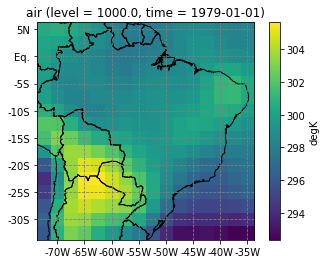

In [ ]:
dss.air[0,:,:].salem.quick_map()

Agora vamos selecionar somente os dados sobre o Brasil, de fato.

Para isso, utilizamos o comando `roi` (region of interest).

In [ ]:
dsr = dss.salem.roi(shape=shdf)

In [ ]:
dsr

<xarray.Dataset>
Dimensions:    (lat: 36, lon: 36, nbnds: 2, time: 507)
Coordinates:
    level      float32 1e+03
  * lat        (lat) float32 30.0 27.5 25.0 22.5 ... -50.0 -52.5 -55.0 -57.5
  * lon        (lon) float32 -97.5 -95.0 -92.5 -90.0 ... -17.5 -15.0 -12.5 -10.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-03-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds, lat, lon) datetime64[ns] NaT NaT NaT ... NaT NaT
    air        (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by Hoop (netCDF2.3)\nConverted to chunked...
    pyproj_srs:     +proj=longlat +datum=WGS84 +no_defs

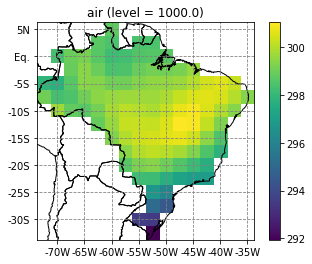

In [ ]:
#Fazendo um mapa rápido com a média da temperatura
dsr.air.mean(dim='time').salem.quick_map()

**Exercício**: Leia os arquivos *mslp.mon.mean.nc* e *precip.mon.mean.nc* contindos na pasta *dados_NCEP_NOAA* do drive compartilhado e faça as seguintes operações:

a) Utilize o `salem` para selecionar um país de sua preferência. Em seguida, aplique a máscara nos dados de pressão e precipitação.

b) Para os países selecionados, gere os gráficos das climatologias anuais e sazonais espaciais bem como as séries temporais.

c) Existe alguma tendência nas séries?

